<a href="https://colab.research.google.com/github/haseeb43/Awesome-Profile-README-templates/blob/master/Copy_of_LIHQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIHQ Artificial Speaker** (Long-Inference, High Quality)

This program can be as simple as uploading an audio file, an image of a person to speak it, and clicking run. Or you can create your own audio of whoever you want, add your own reference video for specific head movements, upload a background image or choose greenscreen, paste onto a larger background image/ video, and choose your fps output. See the 'LIHQ Examples' colab for full examples.

The expressions in the output video are highly dependent on the face image. If you plan to use frame interpolation, it may be worth while to generate a short audio clip, copy it to several audio folders, and run the program without interpolation on several different face images, with several different ref_vid_offset values first. Pick the one you like the best and re-run with correct audio and interpolation.

In [1]:
#Check GPU
#T4 is my baseline. P100 is better, V100 is best. I have not tested below T4 (K80)
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 535.104.05, 15360 MiB


# **1) SET UP**

Click run and wait about three minutes.

In [2]:
#Clone repos

#LIHQ
!git clone https://github.com/johnGettings/LIHQ

%cd LIHQ
#Tortoise
!git clone https://github.com/neonbjb/tortoise-tts.git
#FOMM
!git clone https://github.com/AliaksandrSiarohin/first-order-model
#Wav2Lip
!git clone https://github.com/Rudrabha/Wav2Lip.git
#GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
#QVI
!git clone https://github.com/xuxy09/QVI
#MODNet
!git clone https://github.com/ZHKKKe/MODNet


###LIHQ
!pip install -r requirements.txt

###Tortoise
%mv '/content/LIHQ/tortoise-tts' '/content/LIHQ/tortoise_tts'
%cd /content/LIHQ/tortoise_tts
!python3 setup.py install

###FOMM
%mv '/content/LIHQ/first-order-model' '/content/LIHQ/first_order_model'
%cd /content/LIHQ/first_order_model
#getting model weights
!gdown --id 1DbjXD2nS3jlyCWoJu2HGcLZZjhLC9a2J

###Wav2Lip
%cd /content/LIHQ/Wav2Lip
#Downloading model weights
!gdown --id 1eAtM-Ck5RMyMMZoQuoQfYZRU5vDDwBpK -O './checkpoints/wav2lip_gan.pth'
!gdown --id 1eAtM-Ck5RMyMMZoQuoQfYZRU5vDDwBpK -O './checkpoints/wav2lip.pth'
!wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O "./face_detection/detection/sfd/s3fd.pth"

#GFPGAN
%cd /content/LIHQ/GFPGAN
!python setup.py develop
!pip install realesrgan  # used for enhancing the background (non-face) regions
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

###QVI
%cd /content/LIHQ/QVI
!wget https://www.dropbox.com/s/5auirpk1tijxo1v/model.pt?dl=0 -O './model.pt'
!wget https://www.dropbox.com/s/afsqhlzu0rarpmf/pwc-checkpoint.pt?dl=0 -O './utils/pwc-checkpoint.pt'
%rm './demo.py'
!gdown --id 1xl7ziToar2ZDNpToOOKc8fugw1xeQ6fp -O './demo.py'

###MODNET
%cd /content/LIHQ/MODNet
!gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz -O pretrained/modnet_photographic_portrait_matting.ckpt

%cd /content/LIHQ

Cloning into 'LIHQ'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 238 (delta 18), reused 18 (delta 7), pack-reused 198
Receiving objects: 100% (238/238), 109.17 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/LIHQ
Cloning into 'tortoise-tts'...
remote: Enumerating objects: 1900, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1900 (delta 56), reused 71 (delta 29), pack-reused 1789
Receiving objects: 100% (1900/1900), 54.16 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (866/866), done.
Updating files: 100% (580/580), done.
Cloning into 'first-order-model'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 393 (delta 41), reused 66 (delta 38), pack-reused 312
Receiving objects: 100% (393/393

# **2) Audio**

You have two options here.

1) Add your own audio files into the audio folder. Preferrably single speaker, no background noise. Read the audio folder structure notes below. You can use websites like fakeyou.com, uberduck.ai, or 15.ai to generate text to speech audio files of pop culture characters saying whatever you want (for free).

2) Run your own text to speech below. I have chosen TorToiSe because you are able to quickly and easily replicate a voice of your choosing. Alternatively, you can swap out TorToiSe for something like TacoTron2 or VITS with pretrained VTCK dataset, which has 110 open source UK male and female voices ready to go with good naturalness and reliability. Look at the LIHQ Examples colab for an idea on how to use VITS instead.

**I HIGHLY RECOMMEND** using the silence padding cell below, for around 500ms of silence before your audio. FOMM works better with lip movement if the first frame has a closed mouth.

In [3]:
#Understanding Audio folder structure

# audio
#    |
#    |----Folder1
#    |       |------ 1.wav
#    |       |------ 2.wav
#    |       |------ 3.wav
#    |----Folder2
#    |       |------ 1.wav
#    |----Folder3
#            |------ etc...


# Create subfolders in the audio main directory as seen above. Final videos will be named after subfolder.
# You can put one or many audio files in each folder.
# All audio files within a subfolder will be concatenated and made into one single video. LABEL AUDIO NUMERICALLY/ ALPHABETICALLY so it can be combined in the correct order.
# So with the example above, one 'Folder1.mp4' video will be created using the concatenation of 1.wav, 2.wav, and 3.wav. Folder2.mp4 will only speak 1.wav. etc.

**TorToiSe**

Please see the TorToiSe github for more detailed instructions. https://github.com/neonbjb/tortoise-tts. In short, create a new 'voice' folder in the TorToiSe 'voices' subdirectory with three or more (approximately) 10 second audio files of a target speaker. It works best with clean audio, no background noise, and **a similar tone throughout each file**. If your voice does not come out good, try again with the highest preset and longer sentences. If it still sounds bad, try different audio files. More does not always mean better if the quality is bad. Try removing files that do not match the tone or quality of the others.

That being said, TorToiSe does not always work. I have gotten very good results on 'normal' speaking voices but sometimes it takes a little trial and error on more eccentric voices. You need the right audio (clean, clear, and of correct length) or it may come out sounding distorted and nothing like the original. Cartoony voices, fast or high pitched voices, or accents outside of America are the most difficult to work with, and sometimes I just couldn't get a voice to work. When it does work, it works really well though. All voices in the demo video were made using TortToiSe except the male UK voice (VITS) and Rick's catchphrase (ripped from youtube).

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tortoise-tts 3.0.0 requires transformers==4.31.0, but you have transformers 4.35.2 which is incompatible.


In [ ]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [ ]:
!pip install tortoise

In [2]:
!pip install beartype

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install rotary_embedding_torch

In [ ]:
!pip uninstall tortoise

Found existing installation: tortoise 0.1.1
Uninstalling tortoise-0.1.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tortoise-0.1.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tortoise/*
Proceed (Y/n)? Y
  Successfully uninstalled tortoise-0.1.1


In [5]:
!pip install tortoise

In [3]:
# Run this once. Takes about one minute
%cd /content/LIHQ/tortoise_tts
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

import IPython

from tortoise.api import TextToSpeech
from tortoise.utils.audio import load_audio, load_voice, load_voices

from LIHQ.procedures.tortoise_scripts import tortoise_run, tortoise_combo_run

tts = TextToSpeech()

/content/LIHQ/tortoise_tts


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at jbetker/wav2vec2-large-robust-ft-libritts-voxpopuli were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jbetker/wav2vec2-large-robust-ft-libritts-voxpopuli and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.o

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

autoregressive.pth:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_decoder.pth:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

clvp2.pth:   0%|          | 0.00/976M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


vocoder.pth:   0%|          | 0.00/391M [00:00<?, ?B/s]

In [ ]:
text = "Lick. What, is that supposed to be a pun? That's just stupid. It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout."
voice = 'angie' # Choose one from ./tortoise_tts/tortoise/voices subfolders or try 'random'
preset = "high_quality" #Options: {"ultra_fast", "fast", "standard", "high_quality"}.

gen = tortoise_run(tts, text, voice, preset)
IPython.display.Audio(gen.squeeze(0).cpu(), rate = 24000)

Generating autoregressive samples..


 94%|█████████▍| 15/16 [1:46:01<06:47, 407.77s/it]

In [ ]:
# Saving audio from above. Just change the foldername & filename as needed
torchaudio.save('/content/LIHQ/input/audio/Folder1/2.wav', gen.squeeze(0).cpu(), 24000)

**REQUIRED Generate silence**
Add silence padding to the beginning or end of your audio, or between audio clips.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment

silence_duration = 300  # Set duration in milliseconds. 1000 is 1 second
save_path = '/content/LIHQ/input/audio/Folder1/1.wav' #Set this to the correct folder/file name.

silent_segment = AudioSegment.silent(duration=silence_duration)
silent_segment.export(save_path, format="wav")

<_io.BufferedRandom name='/content/LIHQ/input/audio/Folder1/1.wav'>

**Optional Preview Audio Concatenation** To hear what the combined audio will sound like before you run.

In [ ]:
from LIHQ.procedures.av_scripts import preview_audio

preview_audio('/content/LIHQ/input/audio/Folder1') #Set this to the folder you want to listen to

------------------------
# **Restart Runtime After Using Tortoise** (To free up RAM)
------------------------

# **3) Face**

**Face images work best when the subject is forward facing (symmetrical shoulders) and has a closed mouth. An image of a person with a frown looking off to the left will speak with a frown looking off to the left. High quality images work better than low quality. You can run your image through the upscaler below if needed. Images with facial hair are more difficult to get right.** StyleGAN2 Faces work very well and they are already in the correct format. I have included some examples in the Faces folder. And since they are not real people you can use them freely for your projects. If you want to create your own styleGAN2 face, check out the github repo.

# *Image Cropping*

**If you want your own image that is not styleGAN2 you will need to crop it.** Use the 'Image Cropping' code below to automatically crop and align an image to the correct specifications. Image should only have one person visible. It works for some paintings and realistic animated characters if they look human enough but it does not really work for cartoons or animals. If the image does not work for this code below it will probably not work with LIHQ. Save readout values if you want to paste back onto original image with postprocessing.

# *Image Matting*

This is an optional feature if you want your face image to have a different background. The input image and output video will still be a close-up square though. Why this may be useful: 1) You can add a green background to utilize greenscreen in an external program for postprocessing. 2) Having a simpler background could look more realistic, because the background image tends to warp some in the output video. 3) Adding a simple background now could help video matting in postprocessing section. 4) You just want a different background.

-------------------------------------------------

**Image Cropping**

 Run this one cell below to automatically crop your face image to a closeup square image.

In [ ]:
# Replace filepaths below
%cd '/content/LIHQ/procedures/face_align'
from face_crop import crop_face

crop_face(filename = '/content/LIHQ/input/face/myface.jpg',
          outfile = '/content/LIHQ/input/face/myfaceCrop.jpg')

/content/LIHQ/procedures/face_align
myface.jpg: Number of faces detected: 1
Rotation: 1.48 degrees
Crop size: 2359 x 2359
Offset: [479, 85]


**Optional Upscale & Restore** Video results are better when face is high quality. Skip if you already have a hi-res image.

In [ ]:
%cd '/content/LIHQ/GFPGAN'

in_pth = '/content/LIHQ/input/face/GFPGAN' # The directory which holds the images you want upscaled and restored.
out_pth = '/content/LIHQ/output/' #Creates several output folders in this location
!python inference_gfpgan.py -i {in_pth} -o {out_pth} -v 1.3 -s 4 --bg_upsampler realesrgan

/content/LIHQ/GFPGAN
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Processing myfaceCrop.jpg ...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile

**Optional Image Matting** (Replacing Background)

In [ ]:
#Put your cropped face image in LIHQ/input/face/MODNet/input and click run.
%cd '/content/LIHQ/MODNet'
%rm '/content/LIHQ/input/face/MODNet/input/.gitkeep'
%rm -d '/content/LIHQ/input/face/MODNet/input/.ipynb_checkpoints'

!python -m demo.image_matting.colab.inference \
        --input-path /content/LIHQ/input/face/MODNet/input --output-path /content/LIHQ/input/face/MODNet/masks \
        --ckpt-path /content/LIHQ/input/face/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt

/content/LIHQ/MODNet
rm: cannot remove '/content/LIHQ/input/face/MODNet/input/.gitkeep': No such file or directory
rm: cannot remove '/content/LIHQ/input/face/MODNet/input/.ipynb_checkpoints': No such file or directory
Process image: myfaceCrop.jpg


In [ ]:
# Set paths for background_image and face_image (same as above)
# Crop background image to a sqaure resolution as needed, to avoid unwanted stretching

from LIHQ.procedures.matting_scripts import image_matting

# Combining mask, source, and background
background_image = '/content/LIHQ/input/background/room.jpg'
face_image = '/content/LIHQ/input/face/MODNet/input/myfaceCrop.jpg'

mask_folder = '/content/LIHQ/input/face/MODNet/masks'
output_folder = '/content/LIHQ/input/face/MODNet/output'
image_matting(background_image, face_image, mask_folder, output_folder)

# **Arguments**

**face:** Filepath to face image that you want to speak. Must be cropped and aligned using code above. Can be an array. Face[0] will speak the audio from the first audio folder Folder1, face[1] will speak audio from Folder2, and so on. If the lip synching comes out terrible, try a different image of your speaker. Output varies based on the image.

**audio_super:** The parent folder for all your audio files. This superfolder must have subfolders within. Each subfolder will result in one output video, based on the audio inside. See folder structure above. Default is set to '/content/LIHQ/input/audio/'

**reference_vid:** Path to the reference video. This program will use the refrence video to copy blinking and facial/ head movements (excluding the mouth). I have a generic reference video in the 'input' folder that is 18 minutes long with minimal head movement, which is set as the default. Alternatively, you can add your own video to the 'ReferenceVideo' folder. Just make sure it is cropped in the same manner as your face image and is 25 fps. Default is set to '/content/LIHQ/input/refVid/refvid.mp4'

**ref_vid_offset:** LIHQ will automatically chop the ref vid from [0:00 - len_audio] for your video. If you want the start to be offset set ref_vid_offset to 122 (seconds) so that ref_vid is cropped to [2:02 - len_audio+2:02]. This can be an array as well, one offset value for each audio folder. If you do not change this, your speaker will have the same head movements every run. I have found mouth movement works best at ref_vid_offset = 0. Default is set to 0.

**frame_int:** The default frame rate output is 25fps. Frame interpolation can double, triple, quadruple this to make the video look smoother. I think it improves the quality of the output significantly but it takes a very long time to complete. Keep parameter at None if you want to skip the interpolation. Set to 1 for 50 fps, 2 for 75 fps, 3 for 100 fps, etc. Default is None.

**clear_outputs:** Deletes all files in the LIHQ/output folder. Make sure you save all your work before running a second time, or run again with different audio folder names. Defalut is set to True.

**save_path:** Optional save path for final videos. Videos will automatically be saved in ./LIHQ/output/finalVidsOut regardless. But if you plan to leave LIHQ running in the background for a while, you may want them saved to your drive in case google colab automatically disconnects you. Should be a directory with forward slash at end. Ex: '/content/drive/mydrive/LIHQ/' Default is None.

# **4) Main Script**

**Restart runtime** before clicking run to free up some RAM. In case this is your second run or you used TorToiSe.

In [ ]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=969bf3987607c8a2119771269f84bb0b2e0edfe66f5fea7e8c02bdb2716e068b
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U wav2lip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wav2lip: filename=wav2lip-1.2.4-py3-none-any.whl size=12152662 sha256=c40c7bffb2b5d0e4aa54a3e9254fc99a3e7107776d2e2e2e43fcd604d1adcd15
  Stored in directory: /root/.cache/pip/wheels/e1/04/b9/39218e167c9b96795cfb1a29be12ecb23ee68503d392a1a4ad
Successfully built wav2lip


In [ ]:
!pip uninstall librosa

Found existing installation: librosa 0.10.1
Uninstalling librosa-0.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/librosa-0.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/librosa/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1152.py310.1.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1152.py310.2.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1152.py310.nbi
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1152.py310.1.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1152.py310.2.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1152.py310.nbi
    /usr/local/lib/python3.10/dist-packages/librosa/util/__pycache__/guf-utils._localmax-1051.py310.1.nbc
  

In [ ]:
!pip install librosa==0.9.1
!pip install transformers==4.31.0

In [ ]:
###Wav2Lip
%cd /content/LIHQ/Wav2Lip
#Downloading model weights
!gdown --id 1eAtM-Ck5RMyMMZoQuoQfYZRU5vDDwBpK -O './checkpoints/wav2lip_gan.pth'
!gdown --id 1eAtM-Ck5RMyMMZoQuoQfYZRU5vDDwBpK -O './checkpoints/wav2lip.pth'
!wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O "./face_detection/detection/sfd/s3fd.pth"


/content/LIHQ/Wav2Lip
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eAtM-Ck5RMyMMZoQuoQfYZRU5vDDwBpK 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the b

In [ ]:
import os
adir = 'Folder1' # The audio folder that failed. See Wav2Lip output folder to see whats missing.

vid_path = f'{os.getcwd()}/output/FOMM/Round1/{adir}.mp4'
aud_path = f'{os.getcwd()}/input/audio/{adir}/1.wav'
%cd /content/LIHQ/Wav2Lip
# !python inference.py --face ./resources/image/image.png
!python inference.py --checkpoint_path ./checkpoints/wav2lip.pth --face /content/LIHQ/input/face/examples/123456.png --audio /content/LIHQ/input/audio/Folder1/1.wav --outfile /content/test.mp4  --pads 0 20 0 0

/content/LIHQ/Wav2Lip
Using cuda for inference.
Number of frames available for inference: 1
/content/LIHQ/Wav2Lip/audio.py:100: FutureWarning: Pass sr=16000, n_fft=800 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hp.sample_rate, hp.n_fft, n_mels=hp.num_mels,
(80, 25)
Length of mel chunks: 5
  0% 0/1 [00:00<?, ?it/s]
  0% 0/1 [00:00<?, ?it/s]
100% 1/1 [00:04<00:00,  4.05s/it]
Load checkpoint from: ./checkpoints/wav2lip.pth
  0% 0/1 [00:05<?, ?it/s]
Traceback (most recent call last):
  File "/content/LIHQ/Wav2Lip/inference.py", line 280, in <module>
    main()
  File "/content/LIHQ/Wav2Lip/inference.py", line 252, in main
    model = load_model(args.checkpoint_path)
  File "/content/LIHQ/Wav2Lip/inference.py", line 171, in load_model
    checkpoint = _load(path)
  File "/content/LIHQ/Wav2Lip/inference.py", line 162, in _load
    checkpoint = torch.load(checkpoint_path)
  File "/usr/local/lib/python3.10/dist-

In [ ]:
%cd /content/LIHQ
from runLIHQ import run

run(face='/content/LIHQ/input/face/examples/123456.png')

/content/LIHQ
Initializing
Moviepy - Building video ./first_order_model/input-ref-vid/Folder1/Folder1.mp4.
Moviepy - Writing video ./first_order_model/input-ref-vid/Folder1/Folder1.mp4



Moviepy - Done !
Moviepy - video ready ./first_order_model/input-ref-vid/Folder1/Folder1.mp4
Running First Order Motion Model


  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



  0%|          | 0/114 [00:00<?, ?it/s]

FOMM Success!
Running Wav2Lip
Wav2Lip Complete
Beginning restoration and upscaling
Finished Folder1
Completed Restoration Round 1
Round 1 Complete!
Round1 Elapsed Time:
122.97929072380066
Beginning Round 2
First Order Motion Model


  0%|          | 0/110 [00:00<?, ?it/s]

Final restoration and upscaling of Folder1
Round2 Elapsed Time
99.36381983757019
Complete!
Check ./LIHQ/output/finalVidsOut and your save_path if one was set.


# **5) Optional Postprocessing**

Output of LIHQ will always be a close-up square image, but you may expand the background. If you want to perform some post processing, give the image a green backgorund before running and try a video editing software. This may be the easiest, although I haven't tried it.

If you want to keep everything in python you can use MODNet to create a mask of every frame and replace the background with an image/video of your choice. You can either put them at the bottom of the screen or paste them over the original image. Works with video and image backgrounds. I used this for the LIHQ demo video. See Examples colab.

If you are pasting back onto original image, see image cropping cell output above. It gives the values for speaker resize, offset, and rotation. Set bg_resize to False.

In [ ]:
speaker_vid = '/content/LIHQ/output/finalVidsOut/Folder1.mp4' # Your speaker video created by LIHQ
background = '/content/LIHQ/input/background/wall.jpg' # Can be image or video (Final video output will be smallest fps between background vid and speaker vid.)
bg_resize = (1024, 1024) # Set to False or your desired background size in format: (width, height)
spkr_resize = False # Set to False or your desired speaker size in format: (width, height)
offset = [0, 0] # In the form [y, x]. Offset of speaker image onto background, from top left
rotation = 0 #Counterclockwise, in degrees
output_path = "/content/postprocessing.mp4" # EVERYTHING IN POSTPROCESSING FOLDER GETS DELETED AT THE START OF A NEW RUN!
                                    # So save outside of postprocessing folder.

**Preview Based on Parameters Above**

Just run based off initial guess values above. Keep modifying until image looks correct. Then run video matting cell below.

/content/LIHQ
This is just a preview! Run video matting cell below once image is configured correctly.
Original size of Background: 4000 x 4001
Original size of Speaker Video: 1024 x 1024
Offset Required for Center Bottom: [0, 0]
Offset Required for Center Center: [0, 0]
/content/LIHQ/MODNet
Process image: preview.png
/content/LIHQ
0 of 1


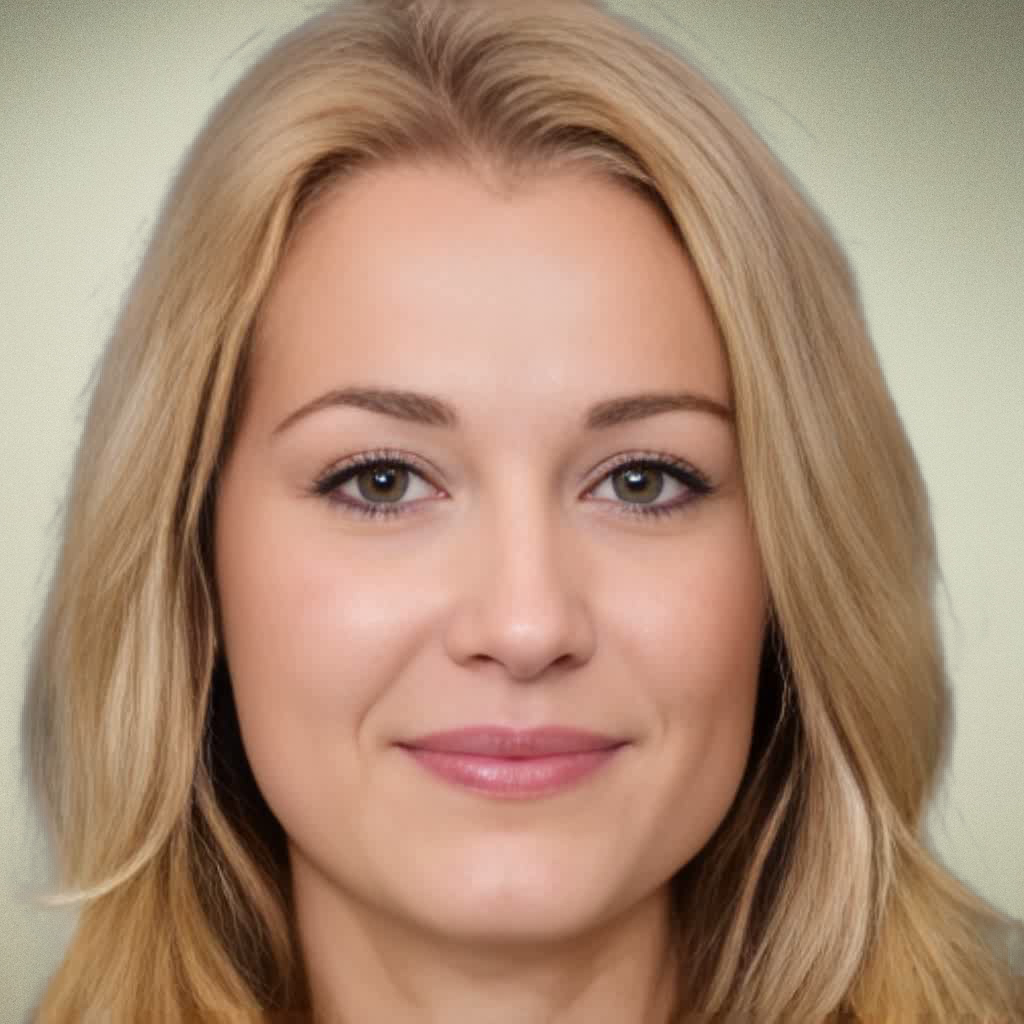

In [ ]:
%cd '/content/LIHQ'

from IPython.display import Image
from pathlib import Path

from procedures.matting_scripts import matte_preview
from procedures.matting_scripts import matte_combine

#Delete Video Matting files from previous run (if any)
for path in Path("./output/postprocessing/").glob("**/*"): #Check path with cwd
    if path.is_file():
        path.unlink()

#Generating image data
matte_preview(speaker_vid, background, bg_resize, spkr_resize, offset)

#Creating mask with MODNet
%cd '/content/LIHQ/MODNet'
!python -m demo.image_matting.colab.inference \
        --input-path /content/LIHQ/output/postprocessing/input \
        --output-path /content/LIHQ/output/postprocessing/masks \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt
%cd '..'

#Combining speaker, mask, background
matte_combine(offset, rotation)

Image('./output/postprocessing/output/preview.png')

**Final Video Matting Based on Parameters Above**

In [ ]:
%cd '/content/LIHQ'

from IPython.display import Image
from pathlib import Path

from procedures.matting_scripts import matte_combine
from procedures.matting_scripts import matte_video

#Delete Video Matting files from previous run (if any)
for path in Path("./output/postprocessing/").glob("**/*"): #Check path with cwd
    if path.is_file():
        path.unlink()

#Generating image data
fps = matte_video(speaker_vid, background, bg_resize, spkr_resize)

#Creating mask with MODNet
%cd '/content/LIHQ/MODNet'
!python -m demo.image_matting.colab.inference \
        --input-path /content/LIHQ/output/postprocessing/input \
        --output-path /content/LIHQ/output/postprocessing/masks \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt
%cd '..'

#Combining speaker, mask, background
matte_combine(offset, rotation)

!ffmpeg -y -framerate {int(fps)} -i '/content/LIHQ/output/postprocessing/output/%5d.png' -i {speaker_vid} -map 0:v:0 -map 1:a:0 -c:v libx264 -pix_fmt yuv420p -b:v 20000k {output_path}

/content/LIHQ
/content/LIHQ/MODNet
Process image: 00007.png
Process image: 00095.png
Process image: 00025.png
Process image: 00047.png
Process image: 00055.png
Process image: 00067.png
Process image: 00049.png
Process image: 00029.png
Process image: 00066.png
Process image: 00100.png
Process image: 00033.png
Process image: 00044.png
Process image: 00038.png
Process image: 00019.png
Process image: 00013.png
Process image: 00090.png
Process image: 00073.png
Process image: 00006.png
Process image: 00070.png
Process image: 00102.png
Process image: 00080.png
Process image: 00003.png
Process image: 00048.png
Process image: 00045.png
Process image: 00031.png
Process image: 00091.png
Process image: 00094.png
Process image: 00046.png
Process image: 00043.png
Process image: 00099.png
Process image: 00071.png
Process image: 00017.png
Process image: 00028.png
Process image: 00106.png
Process image: 00084.png
Process image: 00054.png
Process image: 00086.png
Process image: 00110.png
Process image: 